In [1]:
#import dependencies
import numpy as np
import pandas as pd
import os #for file operations
import glob #for file operations
import json #for creating dataset
import random
import time
from datetime import datetime


import storage
import csv

import spacy

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

### Set global variables to minimize unnecessary processing

In [2]:
STAGE_0 = 0
STAGE_1 = 0
STAGE_2 = 1

### Retrieve & Format Departments (Actors), Articles (Events), Links (Edges)

In [3]:
if(STAGE_0==1):
    # only load departments directly from SQL database if GL has not been calculated.
    departments = storage.retrieve_all_departments()
    department_frame = pd.DataFrame.from_records(departments, columns =['index', 'name', 'lat', 'long'])

article_dept_links = storage.get_article_department_links()
articles = storage.retrieve_all_articles()
article_frame = pd.DataFrame.from_records(articles, columns =['index', 'title', 'journal', 'date', 'abstract', 'grants'])
link_frame = pd.DataFrame.from_records(article_dept_links, columns =['dept0_index', 'dept1_index', 'article_index', 'journal'])


In [4]:
if(STAGE_0):
    department_frame.head()

In [5]:
article_frame.head()

,index,title,journal,date,abstract,grants
0,1,Emergence of community behaviors in the gut mi...,Cell,2024 Sep 19,Pharmaceuticals can directly inhibit the growt...,
1,2,Microbial transformation of dietary xenobiotic...,Cell,2024 Sep 19,Diet is a major determinant of gut microbiome ...,
2,3,Lightinduced remodeling of phytochrome B enabl...,Cell,2024 Sep 16,Phytochrome B (phyB) and phytochromeinteractin...,
3,4,Profound cellular defects attribute to muscula...,Cell,2024 Sep 13,Duchenne muscular dystrophy (DMD) is a progres...,
4,5,m(6)Amodified cenRNA stabilizes CENPA to ensur...,Cell,2024 Sep 18,m(6)A modification is best known for its criti...,


In [6]:
link_frame.head()

,dept0_index,dept1_index,article_index,journal
0,1,2,1,Cell
1,1,3,1,Cell
2,1,4,1,Cell
3,1,5,1,Cell
4,1,6,1,Cell


#### Format Time

In [7]:
article_frame.fillna("--",inplace=True)
article_frame['date']= article_frame['date'].apply(lambda d: d.replace("--","1900 Jan 0"))
article_frame['date'] = article_frame['date'].apply(lambda d: " ".join(d.split(" ")[0:2]))
article_frame['date'] = article_frame['date'].apply(lambda d: datetime.strptime(d, '%Y %b'))
article_frame['date'] = article_frame['date'] = pd.to_datetime(article_frame['date'], format="%m/%d/%Y")


In [8]:
article_frame['date'].describe()

count                             6833
mean     2017-02-28 04:32:42.007902720
min                1900-01-01 00:00:00
25%                2021-08-01 00:00:00
50%                2023-01-01 00:00:00
75%                2024-02-01 00:00:00
max                2024-10-01 00:00:00
Name: date, dtype: object

#### Descriptions of Dataframes Prior to Filtering + Processing

In [9]:
if(STAGE_0):
    department_frame.describe()

In [10]:
article_frame.describe()

,index,date
count,6833.000000,6833
mean,3417.000000,2017-02-28 04:32:42.007902720
min,1.000000,1900-01-01 00:00:00
25%,1709.000000,2021-08-01 00:00:00
50%,3417.000000,2023-01-01 00:00:00
75%,5125.000000,2024-02-01 00:00:00
max,6833.000000,2024-10-01 00:00:00
std,1972.661527,NaN


In [11]:
link_frame.describe()

,dept0_index,dept1_index,article_index
count,952722.000000,952722.000000,952722.000000
mean,24474.605050,24474.605050,2947.714924
std,14132.826415,14132.826415,1770.954414
min,1.000000,1.000000,1.000000
25%,12293.000000,12293.000000,1458.000000
50%,24301.000000,24301.000000,2821.000000
75%,36026.000000,36026.000000,4276.000000
max,52107.000000,52107.000000,6833.000000


## Apply GLiNER

[GLiNER: Generalist Model for Named Entity Recognition using Bidirectional Transformer by Zaratiana et. al](https://arxiv.org/pdf/2311.08526) presents an open named entity resolution model which matches text to a set of natural language entity tags provided at inference time. 

In [12]:
if(STAGE_0):
    #Load Spacy+Gliner Pipeline Pipeline
    nlp = spacy.blank("en")
    #add configs (University, School, Organization)
    custom_spacy_config = { "gliner_model": "urchade/gliner_multi",
                            "chunk_size": 250,
                            "labels": ["university", "school", "organization"],
                            "style": "ent"}
    nlp.add_pipe("gliner_spacy", config=custom_spacy_config)

In [13]:
if(STAGE_0):
    from tqdm import tqdm
    
    tagged_schools = []
    GL_t = []
    texts = department_frame['name'].to_list()
    
    # Use tqdm to track progress
    for doc in tqdm(nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]), total=len(texts)):
        ents_schools = [ent.text for ent in doc.ents if ent.label_ == 'university' or ent.label_ == 'school']
        # if university or school is identified, append to the list
        if len(ents_schools) >= 1:
            tagged_schools.append(ents_schools)
            GL_t.append("S")
        # if a university or school is not identified, look for organizations
        else:
            ents_orgs = [ent.text for ent in doc.ents if ent.label_ == 'organization']
            if len(ents_orgs) >= 1:
                tagged_schools.append(ents_orgs)
                GL_t.append("O")
        # this should just append the actual text itself if no entities are extracted
        # - if a department entity is included it will use that first
        if len(ents_schools) == 0 and len(ents_orgs) == 0:
            tagged_schools.append([doc.text])
            GL_t.append("N")
            
    
    department_frame['GL'] = tagged_schools
    department_frame['GL_t'] = GL_t
    department_frame.to_pickle("./department_frame_GL.pkl") 


We now have a dataframe with GLiNER extracted entities in column *GL*
This has the effect of removing redundant/extraneous information, reducing the chance RELiK focuses on the incorrect entity.

In [14]:
if(STAGE_0):
    department_frame.head()

In [15]:
if(STAGE_1):
    department_frame = pd.read_pickle("./department_frame_GL.pkl")  

In [ ]:
if(STAGE_1):
    from relik import Relik
    from relik.inference.data.objects import RelikOutput
    import torch
    torch.cuda.empty_cache()
    #relik = Relik.from_pretrained("sapienzanlp/relik-entity-linking-large")
    #, device="cuda")?
    relik = Relik.from_pretrained("sapienzanlp/relik-entity-linking-small")


                ___              __         
               /\_ \      __    /\ \        
 _ __     __   \//\ \    /\_\   \ \ \/'\    
/\`'__\ /'__`\   \ \ \   \/\ \   \ \ , <    
\ \ \/ /\  __/    \_\ \_  \ \ \   \ \ \\`\  
 \ \_\ \ \____\   /\____\  \ \_\   \ \_\ \_\
  \/_/  \/____/   \/____/   \/_/    \/_/\/_/
                                            
                                            



/home/aidan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[2024-11-15 15:11:43,168] [INFO] [relik.inference.annotator.from_pretrained:700] [PID:66961] [RANK:0] Loading Relik from sapienzanlp/relik-entity-linking-small
[2024-11-15 15:11:43,171] [INFO] [relik.inference.annotator.from_pretrained:701] [PID:66961] [RANK:0] {
    '_target_': 'relik.inference.annotator.Relik',
    'index': {
        'span': {
            '_target_': 'relik.retriever.indexers.inmemory.InMemoryDocumentIndex.from_pretrained',
            'name_or_path': 'riccorl/retriever-relik-e5-small-entity-linking-aida-wikipedia-index',
        },
    },
    'metadata_fields': [],
    'reader': {
        '_target_': 'relik.reader.pytorch_modules.span.RelikReaderForSpanExtraction',
        'transformer_model': 'sapienzanlp/relik-reader-deberta-v3-base-aida',
        'use_nme': True,
    },
    'retriever': {
        'span': {
            '_target_': 'relik.retriever.pytorch_modules.model.GoldenRetriever',
            'question_encoder': 'riccorl/retriever-relik-e5-small-entity-linki

In [ ]:
if(STAGE_1):
    RelikOutput = relik(department_frame.iloc[0]['GL'][0])
    print(RelikOutput)

In [9]:
department_frame = pd.read_pickle("./relikApplied.pkl")  

In [10]:
department_frame.head()

,original,id,txt
0,Department of Microbial Pathogenesis and Micro...,5307788,"New Haven, Connecticut"
1,Department of Microbial Pathogenesis and Micro...,5307788,"New Haven, Connecticut"
2,"MOE Key Laboratory of Bioinformatics, Center f...",5902060,Tsinghua University
3,"Department of Genetics, Stanford University, S...",681339,Stanford University
4,"MOE Key Laboratory of Bioinformatics, Center f...",5902060,Tsinghua University


In [14]:
department_frame['id'].unique()


array([5307788, 5902060,  681339, 4397544, 3495708, 4843372, 3675141,
       3167155, 2424670, 3963555, 1243316, 1489395, 3461077, 4057481,
       2366469, 5151260,  891457,  934028, 3543740, 4645193, 4975349,
         75642, 4443737,  790000, 4311164, 4335095,  764547,  592546,
       1169657,  922015, 5102115, 3740857, 5136602, 5003250, 5296182,
       5701382, 1474145, 5486299, 2142653, 1990158, 1323152,   20973,
       1399387, 2507570, 3773981,  362457, 3367678, 4486501, 4359671,
       1559742, 1838580, 1725900, 3694148, 5368130, 1496473, 2971095,
       3528390, 4551702, 3109842, 2068926, 2864443, 3297718, 5664482,
       3248335,  188650, 1856874, 1714007, 1210788, 2450556, 2643978,
       2884140, 2536366, 3552863, 3050545, 4349816, 4911391, 1874327,
       3790775,  154421, 1063663, 1100790, 4794670, 5834487, 5325821,
       3365339, 2898422, 3556508, 4775769, 3056837, 1342088, 3479059,
       3937288,  149788,  899526, 1139172,  733055,  659398,  955940,
       5603307, 5102

In [16]:
import networkx as nx
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
for i in range(0, len(department_frame)):
    G.add_node(department_frame.iloc[i]['id'])
    

In [17]:
G.number_of_nodes()

341

In [ ]:
for i in range(0, len(article_dept_links)):
    a = link_frame.iloc[i]['dept0_index']
    b = link_frame.iloc[i]['dept1_index']
    print(str(a), "-->", str(b))
    try:
        a_id = department_frame.iloc[a]['id']
        b_id = department_frame.iloc[b]['id']
        G.add_edge(a_id, b_id)
    except:
        pass

1 --> 2
1 --> 3
1 --> 4
1 --> 5
1 --> 6
1 --> 7
1 --> 8
1 --> 9
1 --> 10
1 --> 11
1 --> 12
1 --> 13
2 --> 1
2 --> 3
2 --> 4
2 --> 5
2 --> 6
2 --> 7
2 --> 8
2 --> 9
2 --> 10
2 --> 11
2 --> 12
2 --> 13
3 --> 1
3 --> 2
3 --> 4
3 --> 5
3 --> 6
3 --> 7
3 --> 8
3 --> 9
3 --> 10
3 --> 11
3 --> 12
3 --> 13
4 --> 1
4 --> 2
4 --> 3
4 --> 5
4 --> 6
4 --> 7
4 --> 8
4 --> 9
4 --> 10
4 --> 11
4 --> 12
4 --> 13
5 --> 1
5 --> 2
5 --> 3
5 --> 4
5 --> 6
5 --> 7
5 --> 8
5 --> 9
5 --> 10
5 --> 11
5 --> 12
5 --> 13
6 --> 1
6 --> 2
6 --> 3
6 --> 4
6 --> 5
6 --> 7
6 --> 8
6 --> 9
6 --> 10
6 --> 11
6 --> 12
6 --> 13
7 --> 1
7 --> 2
7 --> 3
7 --> 4
7 --> 5
7 --> 6
7 --> 8
7 --> 9
7 --> 10
7 --> 11
7 --> 12
7 --> 13
8 --> 1
8 --> 2
8 --> 3
8 --> 4
8 --> 5
8 --> 6
8 --> 7
8 --> 9
8 --> 10
8 --> 11
8 --> 12
8 --> 13
9 --> 1
9 --> 2
9 --> 3
9 --> 4
9 --> 5
9 --> 6
9 --> 7
9 --> 8
9 --> 10
9 --> 11
9 --> 12
9 --> 13
10 --> 1
10 --> 2
10 --> 3
10 --> 4
10 --> 5
10 --> 6
10 --> 7
10 --> 8
10 --> 9
10 --> 11
10 --> 12

In [22]:
G.number_of_edges()

5328

In [43]:
reachability_matrix = np.zeros((len(G.nodes()), len(G.nodes())))
print(reachability_matrix.shape)

(341, 341)


In [48]:
count_i=0
for i in G.nodes:
    count_j=0
    for j in G.nodes:
        reachability_matrix[count_i][count_j] = nx.has_path(G, i, j)
        #reachability_matrix[count_i][count_j] = nx.has_path(G, i, j)
        count_j+=1
    count_i+=1

                

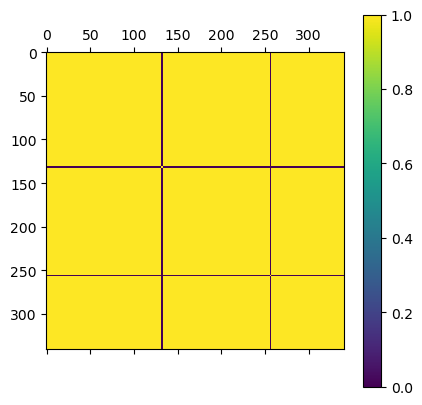

In [50]:
import numpy as np
import matplotlib.pyplot as plt
plt.matshow(reachability_matrix)
plt.colorbar()
plt.savefig('reachability.png')
plt.show()

In [59]:
row_sums = np.sum(reachability_matrix, axis=1)
sorted_indices = np.argsort(row_sums)
bottom_10_indices = sorted_indices[:10]

In [76]:
for x in bottom_10_indices:
    ids = G.nodes()
    #print(x)
    id = list(ids)[x]
    print(department_frame[department_frame['id'] == id]['original'].values)
    low_reaching_i = department_frame[department_frame['id'] == id].index[0]
    low_i_journals = link_frame[link_frame['dept0_index'] == low_reaching_i].journal.tolist()+link_frame[link_frame['dept1_index'] == low_reaching_i].journal.tolist()
    print(len(low_i_journals))
    print(low_i_journals)

['School of Biological and Population Health Sciences, Oregon State University, Corvallis, Oregon, USA.']
0
[]
['Health & Exercise Sciences, College of Nursing and Health Sciences, Flinders University, Adelaide, Australia.']
2
['Cell', 'Cell']
["Institute of Molecular Biology & Translational Medicine, The Affiliated People's Hospital, Jiangsu University, No. 8 Dianli Road, Zhenjiang, Jiangsu, China."]
2
['Cell', 'Cell']
['University for Development Studies, School of Allied Health Sciences, P O Box 1883, Tamale, Ghana.']
18
['Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell']
['Food Science and Nutrition, Department of Health Sciences, Central Washington University, 400 E University Way, Ellensburg, WA98926, USA.']
18
['Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell', 'Cell']
['Biology Department, Boston Colleg